In [37]:
import cv2
import pymeanshift as pms
import matplotlib.pyplot as plt
%matplotlib inline

# Mean shift image segmentation

In [38]:
original_image = cv2.imread("./pymeanshift/examples/example-orig.jpg")

In [39]:
(segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6, 
                                                              range_radius=4.5, min_density=50)

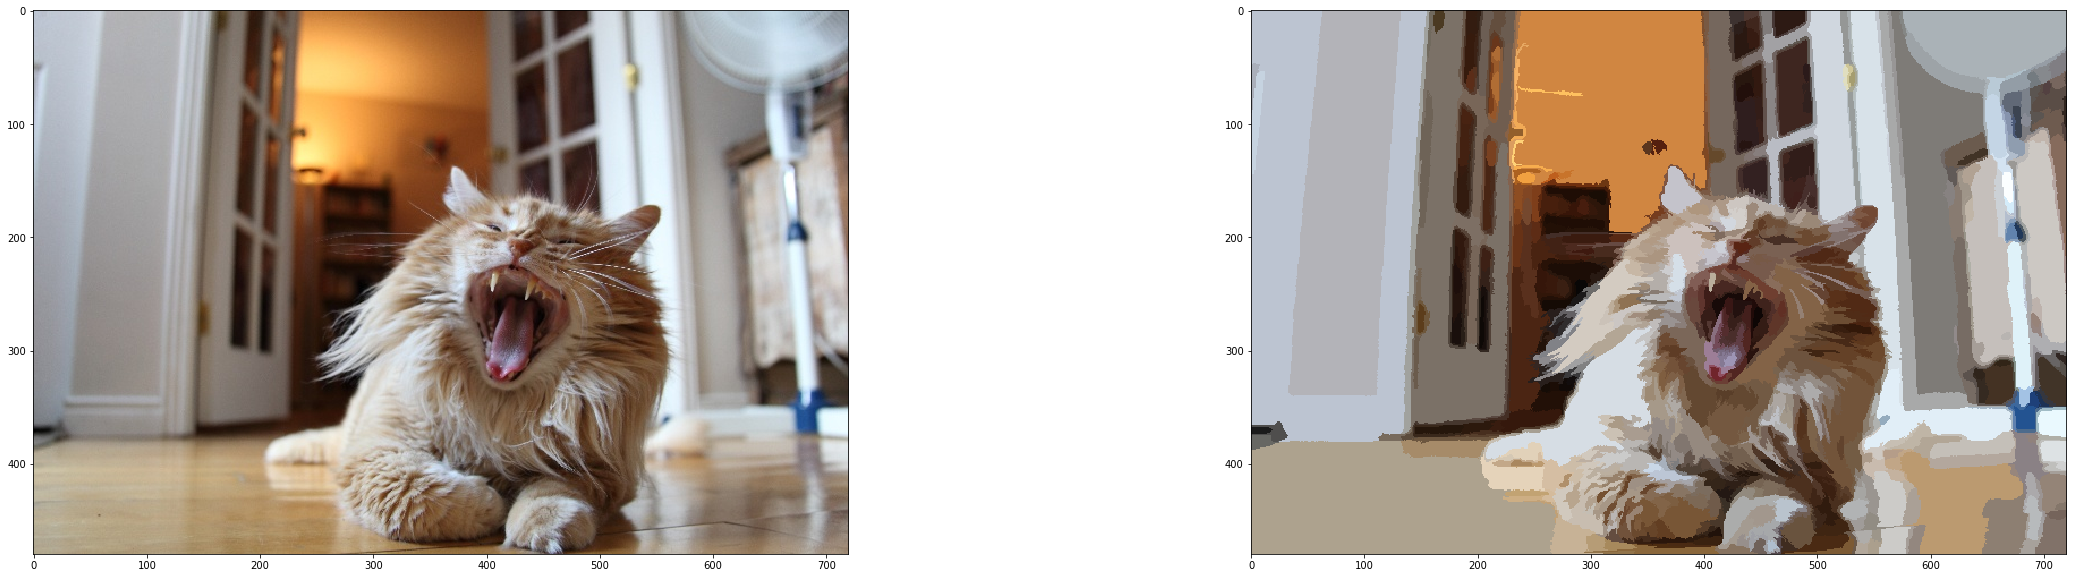

In [40]:
plt.figure(figsize = (40,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.show()

In [41]:
number_regions

875

In [42]:
# (segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6, 
#                                                               range_radius=4.5, min_density=50)

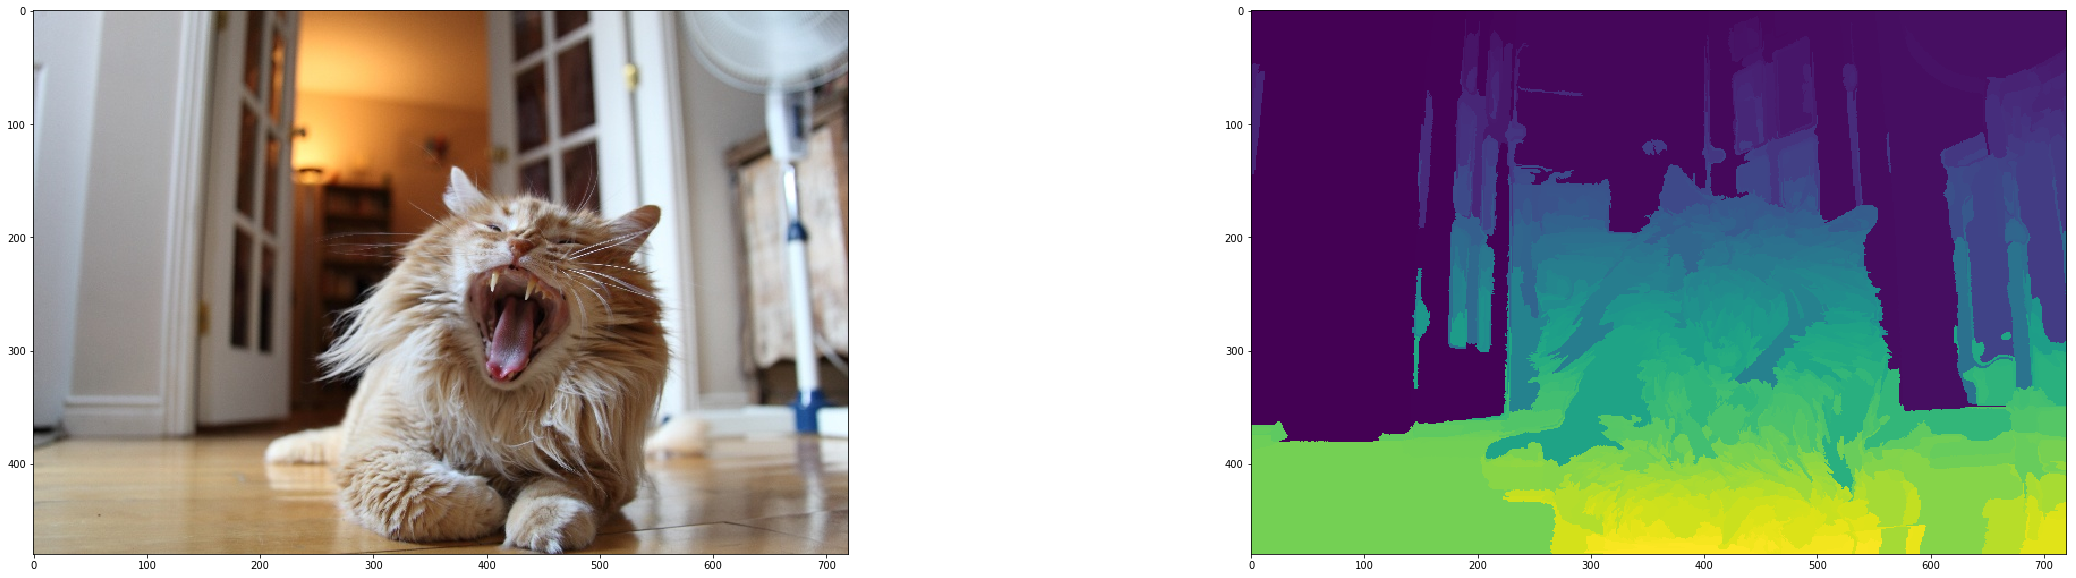

In [43]:
plt.figure(figsize = (40,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(labels_image)
plt.show()

223


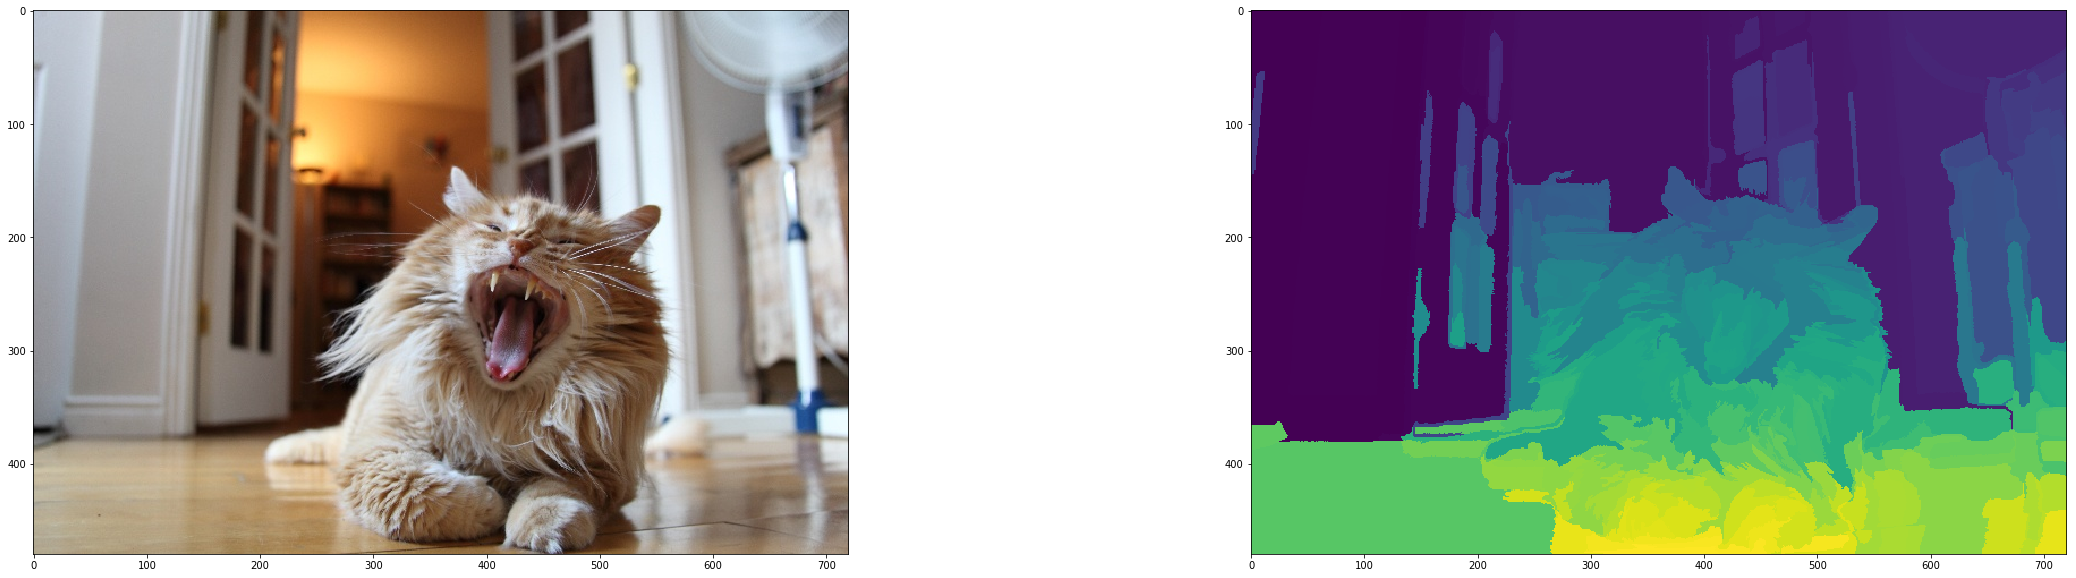

In [44]:
(segmented_image, labels_image, number_regions) = pms.segment(original_image, spatial_radius=6, 
                                                              range_radius=4.5, min_density=300)

print(number_regions)
plt.figure(figsize = (40,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(labels_image)
plt.show()

# Watershed algorithm

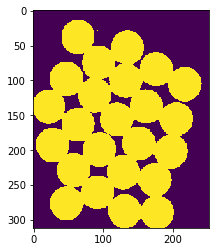

In [48]:
# 任何一副灰度图像 可以 看成拓扑平面
# 灰度值高的区域可以 看成是 山峰 
# 灰度值低的区域可以 看成是山谷。
# 我们向每一个山谷中灌不同颜色的水。随着水的位的升  不同山谷的水就会相遇汇合 
# 为了防止不同山 的水 汇合 我们需要在水汇合的地方构建 堤坝。不停的灌水 不停的构建堤坝
# 直到所有的山峰都被水淹没。
# 我们构建好的堤坝就是对图像的分割。 
# 这就是分水岭算法的背后哲理。
# 每一次灌水 我们的标签就会 更新 当两个不同 色的标签相 时就构建堤 坝 直到将所有山峰淹没 最后我们得到的 界对  堤坝 的值为 -1

img = cv2.imread("water_coins.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh)

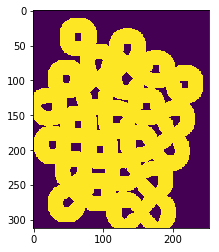

In [49]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)
# Finding sure foreground area
# 距离变换的基本含义是计算一个图像中非像素点到最近的零像素点的距离
# 也就是到零像素点的最短距离
# 个最常见的距离变换算法就是通过连续的腐蚀操作来实现,
# 腐蚀操作的停止条件是所有前景像素都被完全腐蚀。
# 这样根据腐蚀的先后顺序，我们就得到各个前景像素点到前景中心骨架像素点的距离
# 根据各个像素点的距离值，设置为不同的灰度值。这样就完成了二值图像的距离变换
# cv2.distanceTransform(src, distanceType, maskSize)
# 第二个参数 0,1,2 分别 示 CV_DIST_L1, CV_DIST_L2 , CV_DIST_C
dist_transform = cv2.distanceTransform(opening, 1, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)#图像相减
plt.imshow(unknown)

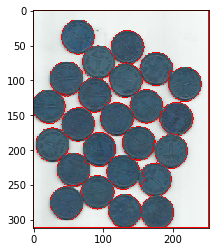

In [50]:
# Marker labelling创建标签
ret, markers1 = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
# 把将背景标 为 0 其他的对 使用从 1 开始的正整数标
markers = markers1 + 1
# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# cv2.imshow('markers', markers1)

# 到最后一步 实施分水岭算法了。标签图像将会 修 改  界区域的标 将变为 -1
markers3 = cv2.watershed(img, markers)
img[markers3 == -1] = [255, 0, 0]

plt.imshow(img)

# Superpixel SLIC

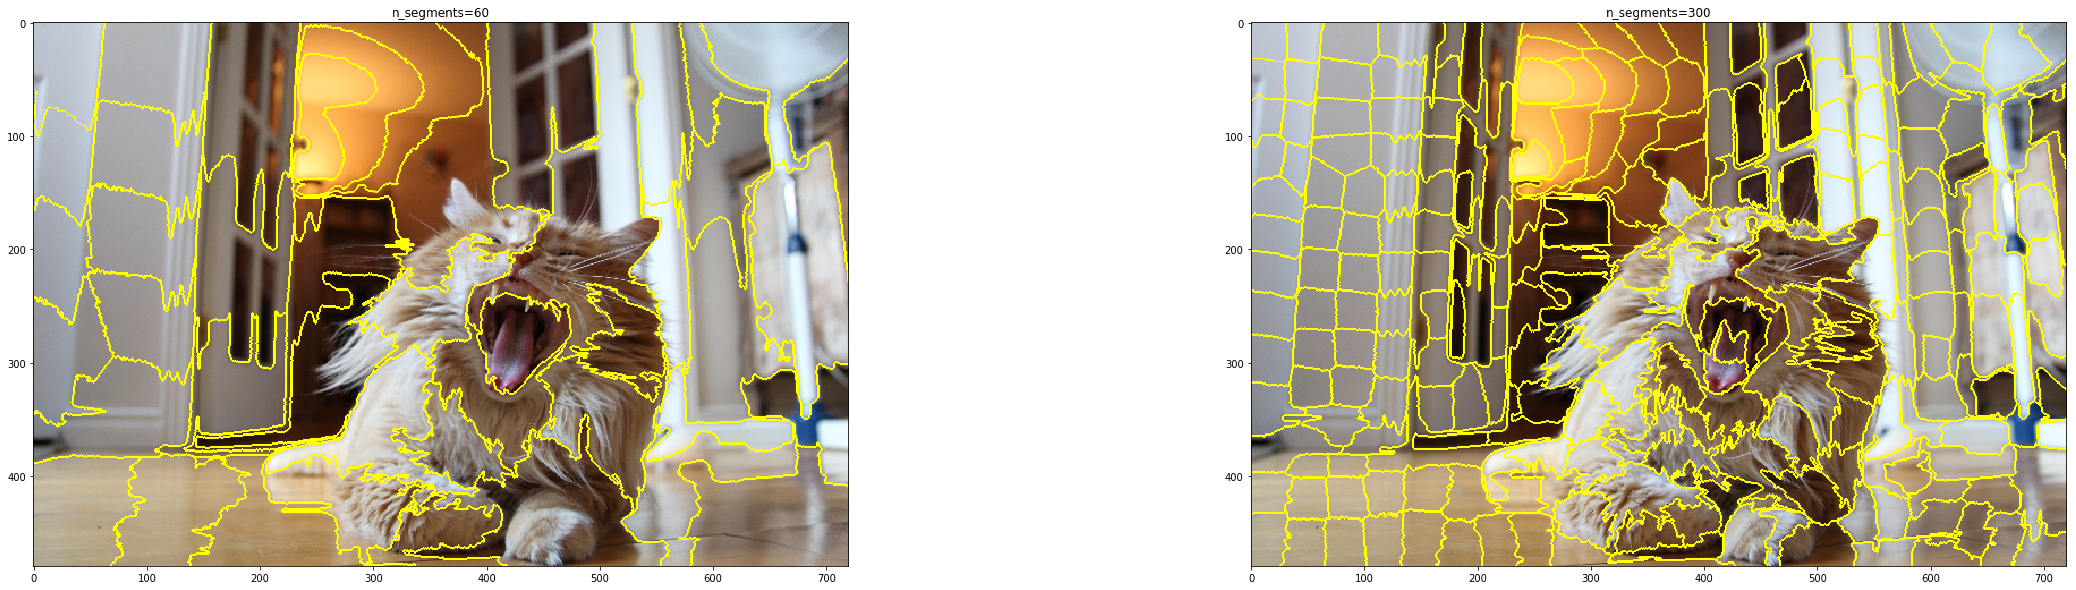

In [32]:
from skimage.segmentation import slic,mark_boundaries
from skimage import io
import matplotlib.pyplot as plt
# import numpy as np
#
# np.set_printoptions(threshold=np.inf)

img = io.imread("./pymeanshift/examples/example-orig.jpg")


segments = slic(img, n_segments=60, compactness=10)
plt.figure(figsize = (40,10))
out=mark_boundaries(img,segments)
# print(segments)
plt.subplot(121)
plt.title("n_segments=60")
plt.imshow(out)

segments2 = slic(img, n_segments=300, compactness=10)
out2=mark_boundaries(img,segments2)
plt.subplot(122)
plt.title("n_segments=300")
plt.imshow(out2)

plt.show()

Felzenszwalb number of segments: 633
SLIC number of segments: 215
Quickshift number of segments: 1062


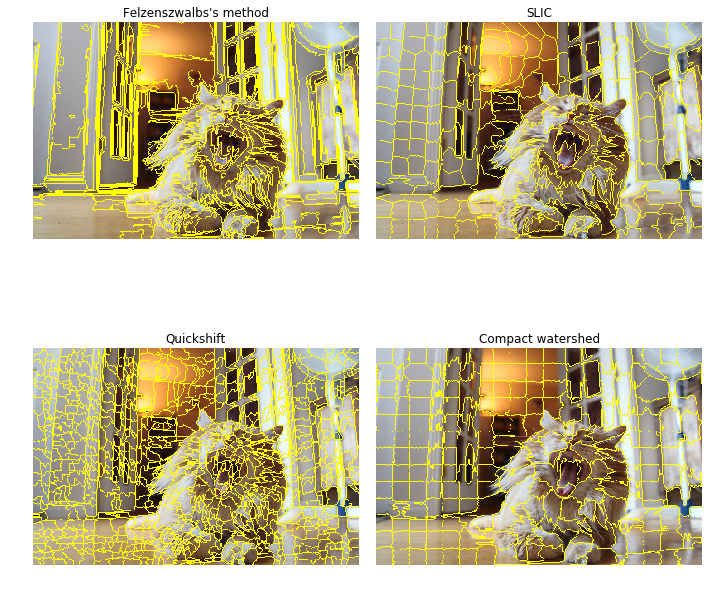

In [35]:
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = io.imread("./pymeanshift/examples/example-orig.jpg")
img = img_as_float(img)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()